In [102]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from tqdm import tqdm
import acd
from copy import deepcopy
sys.path.append('vae')
from model import init_specific_model
from losses import Loss, _get_log_pz_qz_prodzi_qzCx, _get_log_qz_qzi_perb
from dset import get_dataloaders
from training import Trainer
from utils import *
import pickle as pkl
import pandas as pd
from sim_gaussian_mixture import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [128]:
p.num_epochs = 100
p.seed = 13
p.hidden_dim = 12
p.eps = 0.005
p.beta = 0.0
p.mu = 0.1
p.lamPT = 6.9
p.lamCI = 0
p.dirname = 'vary_beta0'

# seed
random.seed(p.seed)
np.random.seed(p.seed)
torch.manual_seed(p.seed)

# GET DATALOADERS
(train_loader, train_latents), (test_loader, test_latents) = define_dataloaders(p)

# PREPARES MODEL
model = init_specific_model(orig_dim=p.orig_dim, latent_dim=p.latent_dim, hidden_dim=p.hidden_dim)
model = model.to(device)

# TRAINS
optimizer = torch.optim.Adam(model.parameters(), lr=p.lr)
loss_f = Loss(beta=p.beta, mu=p.mu, lamPT=p.lamPT, lamCI=p.lamCI,
              alpha=p.alpha, gamma=p.gamma, tc=p.tc, 
              eps=p.eps, p_batch_size=p.p_batch_size, is_mss=True)
trainer = Trainer(model, optimizer, loss_f, device=device)
# trainer(train_loader, test_loader, epochs=p.num_epochs)

In [129]:
data = iter(train_loader).next().to(device)
recon_data, latent_dist, latent_sample = model(data)
latent_output = trainer.latent_map(latent_sample, data)
n_data = train_loader.dataset.data.shape[0]
batch_size, latent_dim = latent_sample.shape
loss_f(data, recon_data, latent_dist, latent_sample, n_data, latent_output)

tensor(800.1410, device='cuda:0', grad_fn=<AddBackward0>)

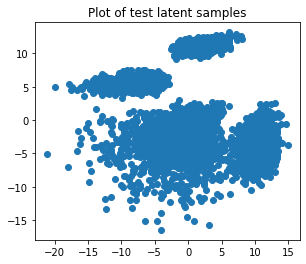

In [76]:
# EVALUATE TEST DATA
data = test_loader.dataset.data.to(device)
recon_data, latent_dist, latent_sample = model(data)
plot_2d_latent_samples(latent_sample)
plt.title("Plot of test latent samples")
plt.show()

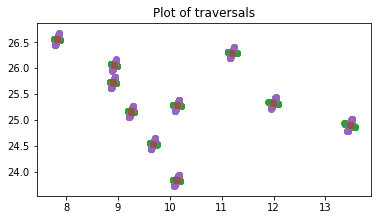

In [77]:
plot_traversals(model, data, lb=4000, ub=5000, num=10)
plt.title("Plot of traversals")
plt.show()

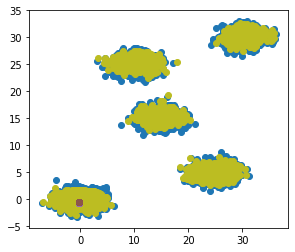

In [78]:
plot_traversals(model, data, lb=0, ub=1000, num=1,
                draw_data=True, draw_recon=True)

In [79]:
# # calculate losses
print('calculating losses and metric...')    
print(calc_disentangle_metric(model, test_loader).mean().item())
# rec_loss, kl_loss, mu_loss, mi_loss, tc_loss, dw_kl_loss, li_loss = calc_losses(model, test_loader, loss_f)
# s.reconstruction_loss = rec_loss
# s.kl_normal_loss = kl_loss
# s.total_correlation = tc_loss
# s.mutual_information = mi_loss
# s.dimensionwise_kl_loss = dw_kl_loss
# if p.attr > 0:
#     s.attribution_loss = attr_loss
# s.disentanglement_metric = calc_disentangle_metric(model, test_loader).mean()
# s.net = model    

calculating losses and metric...
0.13318470120429993


## Local independence

In [ ]:
n_data = train_loader.dataset.data.shape[0]

data = iter(train_loader).next().to(device)
recon_data, latent_dist, latent_sample = model(data)

batch_size, latent_dim = latent_sample.shape

log_pz, log_qz, log_qzi, log_prod_qzi, log_q_zCx = _get_log_pz_qz_prodzi_qzCx(latent_sample,
                                                                              latent_dist,
                                                                              n_data,
                                                                              is_mss=True)  

attr_loss = 0
log_q_zCzi = log_qz.view(batch_size, 1) - log_qzi

eps_batch = 50
eps = 0.1
deltas = 2 * eps * torch.rand(eps_batch) - eps

for i in range(latent_dim):
    perb = torch.zeros(batch_size, latent_dim, eps_batch).to(latent_sample.device)
    perb[:,i] = deltas.view(1, eps_batch) * torch.ones(batch_size, 1)
    latent_sample_p = latent_sample.unsqueeze(2) + perb

    log_qz_p, log_qzi_p = _get_log_qz_qzi_perb(latent_sample_p, latent_dist, n_data, is_mss=True)
    log_q_zCzi_p = log_qz_p.view(batch_size, 1, eps_batch) - log_qzi_p   
    diff = (log_q_zCzi_p - log_q_zCzi.unsqueeze(2))[:,i,:]
    diff2 = (torch.exp(log_q_zCzi_p) - torch.exp(log_q_zCzi.unsqueeze(2)))[:,i,:]
    attr_loss += abs(diff).mean()

In [ ]:
diff = (log_q_zCzi_p - log_q_zCzi.unsqueeze(2))[:,i,:]

In [ ]:
torch.nn.L1Loss()(diff, torch.zeros_like(diff))

In [ ]:
abs(diff).sum()

In [ ]:
abs(diff).mean()